In [36]:
from glob import glob 
import numpy as np 
import xarray as xr
import rioxarray

# find all nc files
files = glob("../data/raw/**/*.nc",recursive=True)

for f in files:
    print(f)

../data/raw/UKCP2.2/tasmax/01/latest/tasmax_rcp85_land-cpm_uk_2.2km_01_day_19821201-19831130.nc
../data/raw/UKCP2.2/tasmax/01/latest/tasmax_rcp85_land-cpm_uk_2.2km_01_day_19841201-19851130.nc
../data/raw/UKCP2.2/tasmax/01/latest/tasmax_rcp85_land-cpm_uk_2.2km_01_day_19811201-19821130.nc
../data/raw/UKCP2.2/tasmax/01/latest/tasmax_rcp85_land-cpm_uk_2.2km_01_day_19831201-19841130.nc
../data/raw/UKCP2.2/tasmax/01/latest/tasmax_rcp85_land-cpm_uk_2.2km_01_day_19851201-19861130.nc
../data/raw/UKCP2.2/tasmax/01/latest/tasmax_rcp85_land-cpm_uk_2.2km_01_day_19801201-19811130.nc


In [37]:
f0 = files[0]

## Test time requirement

In [38]:
#%timeit ncfile = xr.open_dataset(f0)

## Conversion

In [79]:
ncfile

<xarray.Dataset>
Dimensions:                     (time: 360, grid_latitude: 606,
                                 grid_longitude: 484)
Coordinates:
    rotated_latitude_longitude  int64 0
    ensemble_member             int32 1
  * time                        (time) object 1982-12-01 12:00:00 ... 1983-11...
  * grid_latitude               (grid_latitude) float64 -4.683 -4.647 ... 8.063
  * grid_longitude              (grid_longitude) float64 353.9 354.0 ... 364.3
    ensemble_member_id          |S27 ...
    latitude                    (grid_latitude, grid_longitude) float64 ...
    longitude                   (grid_latitude, grid_longitude) float64 ...
    month_number                (time) int32 ...
    year                        (time) int32 ...
    yyyymmdd                    (time) |S64 ...
Data variables:
    tasmax                      (time, grid_latitude, grid_longitude) float32 ...
Attributes: (12/15)
    collection:      land-cpm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2021-05-11T14:06:53
    domain:          uk
    frequency:       day
    institution:     Met Office Hadley Centre (MOHC), FitzRoy Road, Exeter, D...
    ...              ...
    resolution:      2.2km
    scenario:        rcp85
    source:          UKCP18 realisation from a set of 12 convection-permittin...
    title:           UKCP18 land projections - 2.2km convection-permitting cl...
    version:         v20210615
    Conventions:     CF-1.7

In [56]:
# Don't need the extra dims - AFAIK
ncfile = xr.open_dataset(f0).drop_dims("bnds").squeeze()
ncfile = ncfile.rio.set_spatial_dims('grid_longitude', 'grid_latitude')
ncfile.rio.write_crs("epsg:27700", inplace=True)
del ncfile["tasmax"].attrs['grid_mapping'] # need to drop this too in order to size properly
f0_n = f0.replace(".nc","geotiff.tiff")
ncfile["tasmax"].rio.to_raster(f0_n)

In [81]:
geotiff = xr.open_dataset(f0_n, engine='rasterio')
geotiff

<xarray.Dataset>
Dimensions:      (band: 360, x: 484, y: 606)
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360
  * x            (x) float64 353.9 354.0 354.0 354.0 ... 364.2 364.3 364.3 364.3
  * y            (y) float64 -4.683 -4.662 -4.641 -4.62 ... 8.021 8.042 8.063
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [73]:
geotiff

<xarray.Dataset>
Dimensions:      (band: 360, x: 484, y: 606)
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360
  * x            (x) float64 353.9 354.0 354.0 354.0 ... 364.2 364.3 364.3 364.3
  * y            (y) float64 -4.683 -4.662 -4.641 -4.62 ... 8.021 8.042 8.063
    spatial_ref  int64 0
Data variables:
    band_data    (band, y, x) float32 ...

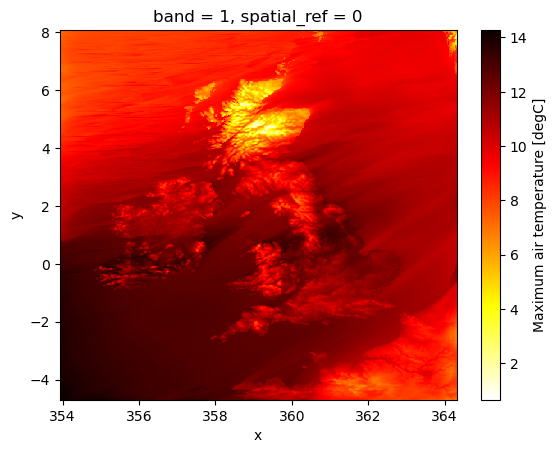

In [93]:
da = geotiff.isel(band=0).band_data.expand_dims({"band":1})
# exclude vals below or equal to 0, squeeze to 2d and plot
da.where(da>=0).squeeze().plot.imshow(cmap="hot_r")